<a href="https://colab.research.google.com/github/WoradeeKongthong/face_recognition_with_VGGFace/blob/main/training_face_recognition_with_VGGFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
! pip install Keras-Applications

     |████████████████████████████████| 50 kB 6.2 MB/s 


In [2]:
# install VGGFace2 from repository
!pip install git+https://github.com/yaledhlab/vggface.git

  Cloning https://github.com/yaledhlab/vggface.git to /tmp/pip-req-build-o7yped2p
  Running command git clone -q https://github.com/yaledhlab/vggface.git /tmp/pip-req-build-o7yped2p


In [5]:
import os
from keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split
from keras_vggface.vggface import VGGFace
from keras.layers import Flatten, Dense
from keras.models import Model
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Get dataset

In [ ]:
# clone my repository for dataset
! git clone https://github.com/WoradeeKongthong/face_recognition_with_VGGFace.git

In [4]:
%cd face_recognition_with_VGGFace/

/content/face_recognition_with_VGGFace


# Prepare dataset

In [6]:
# get class names
name_list = os.listdir('data/faces')

In [7]:
# create dataset (X,y) for training
images = []
labels = []
name_int_map = {idx:name for idx,name in enumerate(name_list)}
for i, name in enumerate(name_list):
    img_list = os.listdir('data/faces/'+name)
    path_list = [os.path.join('data/faces',name,i) for i in img_list]
    for imgPath in path_list:
        img = image.load_img(imgPath)
        img = img.resize((224,224))
        img = image.img_to_array(img)
        images.append(img)
        labels.append(i)
images = np.array(images)
labels = np.array(labels)

In [8]:
# create in-memory training and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, 
                                                    test_size=0.2, 
                                                    random_state=120)

# Create helper  function

In [62]:
# create function for plotting
def evaluate_model(history, face_recognizer):
    # plot training and validation loss
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(history.history['loss'], color='blue', label='train')
    ax1.plot(history.history['val_loss'], color='orange', label='val')
    ax1.set_title('Loss')
    ax1.set_ylim((0,5))
    ax1.legend()
    
    # evaluation on test set
    y_pred = face_recognizer.predict(X_test)
    y_pred_int = np.argmax(y_pred, axis=1)
    fbeta = fbeta_score(y_test, y_pred_int, beta=2, average='micro')
    print(f"\nf-beta score : {round(fbeta*100,2)}%\n")

    # plot confusion matrix of model prediction
    # fig.add_subplot(122)
    conf_mat = confusion_matrix(y_test, y_pred_int)
    #fig, ax = plt.subplots(figsize=(8, 8))
    dist = ConfusionMatrixDisplay(conf_mat, display_labels=name_int_map.values())
    dist.plot(cmap='YlOrBr', ax= ax2)
    
    plt.show()

# Baseline Model : VGGFace as an integrated feature extractor

Epoch 1/100
14/14 [==============================] - 6s 161ms/step - loss: 1.9902 - val_loss: 0.5029
Epoch 2/100
14/14 [==============================] - 1s 83ms/step - loss: 0.3224 - val_loss: 0.3798
Epoch 3/100
14/14 [==============================] - 1s 83ms/step - loss: 0.1645 - val_loss: 0.2386
Epoch 4/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0838 - val_loss: 0.2320
Epoch 5/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0429 - val_loss: 0.2577
Epoch 6/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0270 - val_loss: 0.2221
Epoch 7/100
14/14 [==============================] - 1s 83ms/step - loss: 0.0174 - val_loss: 0.2352
Epoch 8/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0202 - val_loss: 0.1765
Epoch 9/100
14/14 [==============================] - 1s 81ms/step - loss: 0.0195 - val_loss: 0.2361
Epoch 10/100
14/14 [==============================] - 1s 82ms/step - loss: 0.0113 - val_loss: 0.201

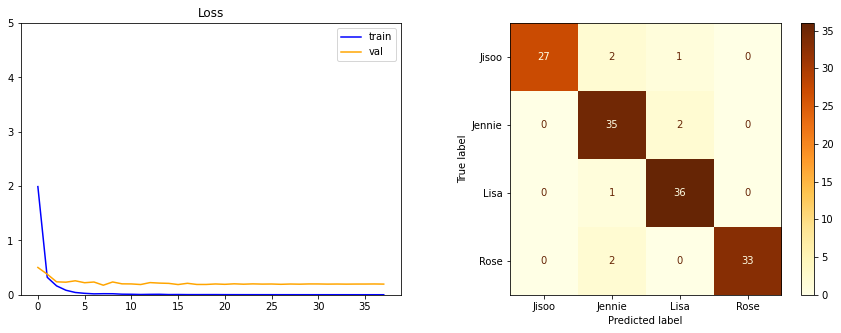

In [66]:
# create face recognition model with VGGFace as an integrated feature extractor
vggface_model = VGGFace(include_top=False, input_shape=(224, 224, 3), model='senet50')
# set layers as untrainable
for layer in vggface_model.layers:
    layer.trainable = False
last_layer = vggface_model.get_layer(index=-1).output
x = Flatten()(last_layer)
output = Dense(4, activation='softmax')(x)
face_recognizer = Model(inputs=vggface_model.input, outputs=output)
face_recognizer.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train the model
history = face_recognizer.fit(X_train, y_train, 
                              batch_size=32, epochs=100, 
                              validation_split=0.2,
                              callbacks=[es])

# evaluation
evaluate_model(history, face_recognizer)

# Improve model

## model 1 : Baseline + one more Dense layer

Epoch 1/300
14/14 [==============================] - 6s 164ms/step - loss: 2.1304 - val_loss: 0.7950
Epoch 2/300
14/14 [==============================] - 1s 83ms/step - loss: 0.4146 - val_loss: 0.4973
Epoch 3/300
14/14 [==============================] - 1s 83ms/step - loss: 0.1499 - val_loss: 0.7507
Epoch 4/300
14/14 [==============================] - 1s 81ms/step - loss: 0.0959 - val_loss: 0.4283
Epoch 5/300
14/14 [==============================] - 1s 82ms/step - loss: 0.0631 - val_loss: 0.6572
Epoch 6/300
14/14 [==============================] - 1s 82ms/step - loss: 0.0063 - val_loss: 0.4462
Epoch 7/300
14/14 [==============================] - 1s 82ms/step - loss: 0.0254 - val_loss: 0.4009
Epoch 8/300
14/14 [==============================] - 1s 83ms/step - loss: 0.0238 - val_loss: 0.5803
Epoch 9/300
14/14 [==============================] - 1s 81ms/step - loss: 0.0252 - val_loss: 0.3789
Epoch 10/300
14/14 [==============================] - 1s 82ms/step - loss: 0.0282 - val_loss: 0.435

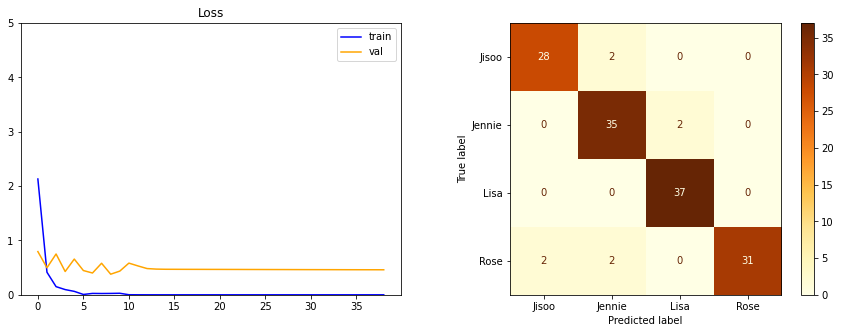

In [67]:
# create face recognition model with VGGFace as an integrated feature extractor
vggface_model = VGGFace(include_top=False, input_shape=(224, 224, 3), model='senet50')
# set layers as untrainable
for layer in vggface_model.layers:
    layer.trainable = False
last_layer = vggface_model.get_layer(index=-1).output
x = Flatten()(last_layer)
x = Dense(512, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
face_recognizer = Model(inputs=vggface_model.input, outputs=output)
face_recognizer.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train the model
history = face_recognizer.fit(X_train, y_train, 
                              batch_size=32, epochs=300, 
                              validation_split=0.2,
                              callbacks=[es])

# evaluation
evaluate_model(history, face_recognizer)

## model 2 : Baseline + set last VGGFace conv block as trainable

Epoch 1/300
14/14 [==============================] - 7s 181ms/step - loss: 3.3159 - val_loss: 492972.9688
Epoch 2/300
14/14 [==============================] - 1s 100ms/step - loss: 0.3335 - val_loss: 39413.5508
Epoch 3/300
14/14 [==============================] - 1s 100ms/step - loss: 0.1424 - val_loss: 5667.1929
Epoch 4/300
14/14 [==============================] - 1s 100ms/step - loss: 0.1129 - val_loss: 1027.3459
Epoch 5/300
14/14 [==============================] - 1s 99ms/step - loss: 0.1190 - val_loss: 283.3296
Epoch 6/300
14/14 [==============================] - 1s 101ms/step - loss: 0.0227 - val_loss: 86.6804
Epoch 7/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0240 - val_loss: 28.6455
Epoch 8/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0113 - val_loss: 11.2840
Epoch 9/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0897 - val_loss: 24.4093
Epoch 10/300
14/14 [==============================] - 1s 100ms/step - lo

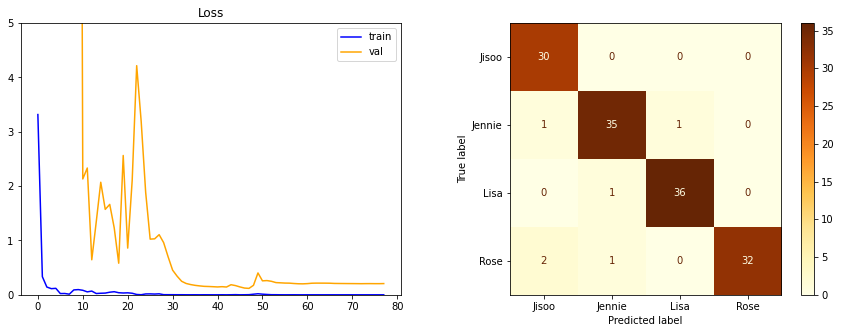

In [68]:
# create face recognition model with VGGFace as an integrated feature extractor
vggface_model = VGGFace(include_top=False, input_shape=(224, 224, 3), model='senet50')
# set layers as untrainable
for layer in vggface_model.layers[:-54]:
    layer.trainable = False
last_layer = vggface_model.get_layer(index=-1).output
x = Flatten()(last_layer)
output = Dense(4, activation='softmax')(x)
face_recognizer = Model(inputs=vggface_model.input, outputs=output)
face_recognizer.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train the model
history = face_recognizer.fit(X_train, y_train, 
                              batch_size=32, epochs=300, 
                              validation_split=0.2,
                              callbacks=[es])

# evaluation
evaluate_model(history, face_recognizer)

## model 3 : Baseline + set last conv block as trainable + one more dense layer

Epoch 1/300
14/14 [==============================] - 7s 185ms/step - loss: 2.9953 - val_loss: 586949.3125
Epoch 2/300
14/14 [==============================] - 1s 106ms/step - loss: 0.3502 - val_loss: 95957.0469
Epoch 3/300
14/14 [==============================] - 1s 102ms/step - loss: 0.2051 - val_loss: 12683.9688
Epoch 4/300
14/14 [==============================] - 1s 101ms/step - loss: 0.0925 - val_loss: 1475.3740
Epoch 5/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0872 - val_loss: 246.9718
Epoch 6/300
14/14 [==============================] - 1s 101ms/step - loss: 0.0560 - val_loss: 78.6306
Epoch 7/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0302 - val_loss: 23.7072
Epoch 8/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0166 - val_loss: 9.8553
Epoch 9/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0193 - val_loss: 3.8106
Epoch 10/300
14/14 [==============================] - 1s 100ms/step - l

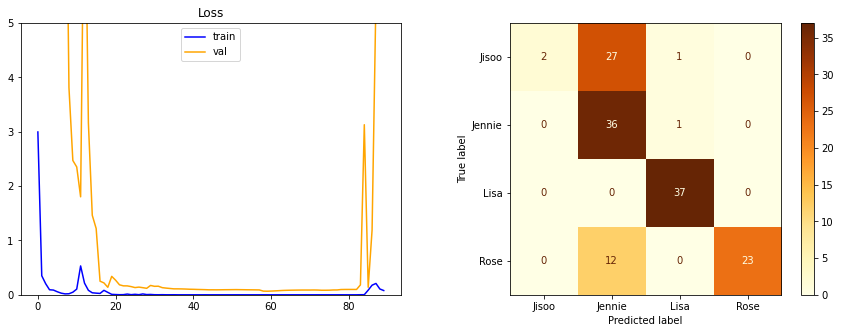

In [69]:
# create face recognition model with VGGFace as an integrated feature extractor
vggface_model = VGGFace(include_top=False, input_shape=(224, 224, 3), model='senet50')
# set layers as untrainable
for layer in vggface_model.layers[:-54]:
    layer.trainable = False
last_layer = vggface_model.get_layer(index=-1).output
x = Flatten()(last_layer)
x = Dense(512, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
face_recognizer = Model(inputs=vggface_model.input, outputs=output)
face_recognizer.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train the model
history = face_recognizer.fit(X_train, y_train, 
                              batch_size=32, epochs=300, 
                              validation_split=0.2,
                              callbacks=[es])

# evaluation
evaluate_model(history, face_recognizer)

# Finalize model

Epoch 1/300
14/14 [==============================] - 7s 183ms/step - loss: 3.2459 - val_loss: 291759.1562
Epoch 2/300
14/14 [==============================] - 1s 99ms/step - loss: 0.2690 - val_loss: 5860.9829
Epoch 3/300
14/14 [==============================] - 1s 99ms/step - loss: 0.1149 - val_loss: 681.0660
Epoch 4/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0878 - val_loss: 220.8833
Epoch 5/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0384 - val_loss: 93.7943
Epoch 6/300
14/14 [==============================] - 1s 100ms/step - loss: 0.0388 - val_loss: 37.2368
Epoch 7/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0443 - val_loss: 25.6348
Epoch 8/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0463 - val_loss: 9.9964
Epoch 9/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0163 - val_loss: 4.2624
Epoch 10/300
14/14 [==============================] - 1s 99ms/step - loss: 0.0295 -

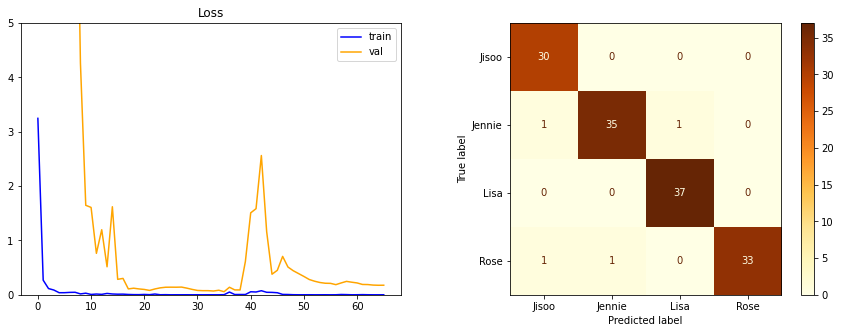

In [70]:
# create face recognition model with VGGFace as an integrated feature extractor
vggface_model = VGGFace(include_top=False, input_shape=(224, 224, 3), model='senet50')
# set layers as untrainable
for layer in vggface_model.layers[:-54]:
    layer.trainable = False
last_layer = vggface_model.get_layer(index=-1).output
x = Flatten()(last_layer)
output = Dense(4, activation='softmax')(x)
face_recognizer = Model(inputs=vggface_model.input, outputs=output)
face_recognizer.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint to save the model
mc = ModelCheckpoint('data/saved_clf/blackpink_clf.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train the model
history = face_recognizer.fit(X_train, y_train, 
                              batch_size=32, epochs=300, 
                              validation_split=0.2,
                              callbacks=[es])

# evaluation
evaluate_model(history, face_recognizer)

# Save the final model to local machine

In [72]:
from google.colab import files
files.download('/content/face_recognition_with_VGGFace/data/saved_clf/blackpink_clf.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Make prediction on image

In [79]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 15.2 MB/s 


In [109]:
import keras
from PIL import Image
import requests
from mtcnn.mtcnn import MTCNN
import cv2

## Load model

In [75]:
model = keras.models.load_model('/content/face_recognition_with_VGGFace/data/saved_clf/blackpink_clf.h5')

## Prediction one person on image

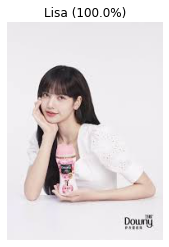

In [93]:
# get image from url
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIysxAcWDGKm5qRXaRhl5OvVnXk_GR-yehGw&usqp=CAU'
img = Image.open(requests.get(url, stream=True).raw)

# convert image to array
img = image.img_to_array(img)

# extract face from the loaded image
face_detector = MTCNN()
faces = face_detector.detect_faces(img)
x, y, w, h = faces[0]['box']
face = img[y:y+h, x:x+w]

# reshape face for input of face recognition (VGGface)
face = image.array_to_img(face)
face = face.resize((224,224))

# convert image to array
face = image.img_to_array(face)

# create batch
sample = np.expand_dims(face, 0)

# create a pre-trained model
face_recognizer = model

# make prediction on well-known celebrity image
prediction = face_recognizer.predict(sample)
# print('Predicted:', decode_predictions(prediction))

# show image and prediction
plt.imshow(img/255.)
plt.axis('off')
plt.title(f"{name_int_map[np.argmax(prediction)]} ({round(np.max(prediction)*100,2)}%)")
plt.show()

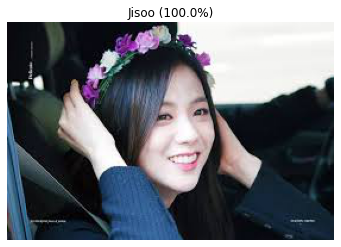

In [94]:
# get image from url
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ3j6COCpfsqz139anHEkjExf2N8FV5MrcBgQ&usqp=CAU'
img = Image.open(requests.get(url, stream=True).raw)

# convert image to array
img = image.img_to_array(img)

# extract face from the loaded image
face_detector = MTCNN()
faces = face_detector.detect_faces(img)
x, y, w, h = faces[0]['box']
face = img[y:y+h, x:x+w]

# reshape face for input of face recognition (VGGface)
face = image.array_to_img(face)
face = face.resize((224,224))

# convert image to array
face = image.img_to_array(face)

# create batch
sample = np.expand_dims(face, 0)

# create a pre-trained model
face_recognizer = model

# make prediction on well-known celebrity image
prediction = face_recognizer.predict(sample)
# print('Predicted:', decode_predictions(prediction))

# show image and prediction
plt.imshow(img/255.)
plt.axis('off')
plt.title(f"{name_int_map[np.argmax(prediction)]} ({round(np.max(prediction)*100,2)}%)")
plt.show()

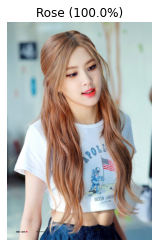

In [95]:
# get image from url
url = 'https://i.pinimg.com/originals/7c/d5/5e/7cd55ee4cc7b38ebe34325f8279a432e.jpg'
img = Image.open(requests.get(url, stream=True).raw)

# convert image to array
img = image.img_to_array(img)

# extract face from the loaded image
face_detector = MTCNN()
faces = face_detector.detect_faces(img)
x, y, w, h = faces[0]['box']
face = img[y:y+h, x:x+w]

# reshape face for input of face recognition (VGGface)
face = image.array_to_img(face)
face = face.resize((224,224))

# convert image to array
face = image.img_to_array(face)

# create batch
sample = np.expand_dims(face, 0)

# create a pre-trained model
face_recognizer = model

# make prediction on well-known celebrity image
prediction = face_recognizer.predict(sample)
# print('Predicted:', decode_predictions(prediction))

# show image and prediction
plt.imshow(img/255.)
plt.axis('off')
plt.title(f"{name_int_map[np.argmax(prediction)]} ({round(np.max(prediction)*100,2)}%)")
plt.show()

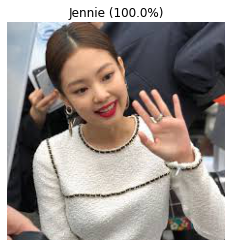

In [97]:
# get image from url
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQLWYvPv2Z2P_nl71qVApxmvt5R7v3mjg_MUA&usqp=CAU'
img = Image.open(requests.get(url, stream=True).raw)

# convert image to array
img = image.img_to_array(img)

# extract face from the loaded image
face_detector = MTCNN()
faces = face_detector.detect_faces(img)
x, y, w, h = faces[0]['box']
face = img[y:y+h, x:x+w]

# reshape face for input of face recognition (VGGface)
face = image.array_to_img(face)
face = face.resize((224,224))

# convert image to array
face = image.img_to_array(face)

# create batch
sample = np.expand_dims(face, 0)

# create a pre-trained model
face_recognizer = model

# make prediction on well-known celebrity image
prediction = face_recognizer.predict(sample)
# print('Predicted:', decode_predictions(prediction))

# show image and prediction
plt.imshow(img/255.)
plt.axis('off')
plt.title(f"{name_int_map[np.argmax(prediction)]} ({round(np.max(prediction)*100,2)}%)")
plt.show()

## Predict many people in one image

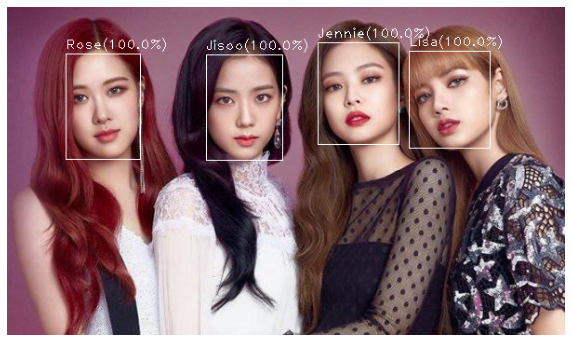

In [121]:
# get image from url
url = 'https://images.droidsans.com/wp-content/uploads/2020/09/blackpink-o-lens-cover-600x353.jpg'
img = Image.open(requests.get(url, stream=True).raw)

# convert image to array
img = image.img_to_array(img)

# extract face from the loaded image
face_detector = MTCNN()
faces = face_detector.detect_faces(img)

# make prediction on each face
for face in faces:

  x, y, w, h = face['box']
  face_img = img[y:y+h, x:x+w]

  # reshape face for input of face recognition (VGGface)
  face_img = image.array_to_img(face_img)
  face_img = face_img.resize((224,224))

  # convert image to array
  face_img = image.img_to_array(face_img)

  # create batch
  sample = np.expand_dims(face_img, 0)

  # make prediction on well-known celebrity image
  prediction = model.predict(sample)

  # draw rectangle and test on image
  cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255), 1)
  text = f"{name_int_map[np.argmax(prediction)]}({round(np.max(prediction)*100,2)}%)"
  cv2.putText(img, text, (x,y-5), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1)

fig = plt.figure(figsize=(10,10))
plt.imshow(img/255.)
plt.axis('off')
plt.show()